## 16.1 Examining the convolutional neural network (CNN)

A convolutional neural network is a deep learning architecture that makes use of the convolution operation. The convolution operation allows the network to create a reduced set of features. Therefore, it is a way of regularizing the network, preventing overfitting, and effectively filtering the inputs. Of course, for this to make sense, you must first understand the convolution operation and how it impacts the inputs.

In mathematical terms, a convolution is an operation on two functions that generates a third function that expresses how the shape of one function is changed by the other. In a CNN, this operation occurs between the inputs and a kernel (also known as a filter). The kernel is simply a matrix that is placed on top of the feature matrix. In figure 16.1, the kernel is slid along the time axis, taking the dot product between the kernel and the features. This results in a reduced set of features, achieving regularization and the filtering of abnormal values.

To better understand the convolution operation, let’s consider a simple example with only one feature and one kernel, as shown in figure 16.2. To make things simple, we’ll consider only one row of features. Keep in mind that the horizontal axis remains the time dimension. The kernel is a smaller vector that is used to perform the convolution operation. Do not worry about the values used inside the kernel and the feature vector. 

They are arbitrary values. The values of the kernel are optimized and will change as the network is trained.

We can visualize the convolution operation and its result in figure 16.3. At first, the kernel is aligned with the beginning of the feature vector and the dot product is taken between the kernel and the values of the feature vector that are aligned with it. Once
this is done, the kernel shifts one timestep to the right—this is also called a stride of one timestep. The dot product is again taken between the kernel and the feature vector, again only with the values that are aligned with the kernel. The kernel again shifts one timestep to the right, and the process is repeated until the kernel reaches the end of the feature vector. This happens when the kernel cannot be shifted any further with all of its values having an aligned feature value.

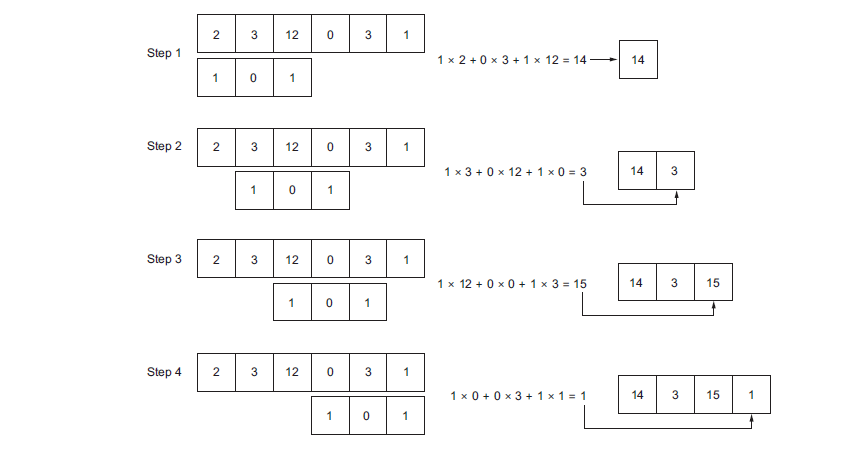

In figure 16.3 you can see that using a feature vector of length 6 and a kernel of length 3, we obtain an output vector of length 4. Thus, in general, the length of the output vector of a convolution is given by equation 16.1.

output length = input length – kernel length + 1 Equation 16.1

Note that since the kernel is moving only in one direction (to the right), this is a 1D convolution. Luckily, Keras comes with the Conv1D layer, allowing us to easily implement it in Python. This is mostly used for time series forecasting, as the kernel can only
move in the time dimension. For image processing, you’ll often see 2D or 3D convolutions, but that is outside of the scope of this book.

A convolution layer reduces the length of the set of features, and performing many convolutions will keep reducing the feature space. This can be problematic, as it limits the number of layers in the network, and we might lose too much information in the process. A common technique to prevent that is padding. Padding simply means adding values before and after the feature vector to keep the output length equivalent to the input length. Padding values are often zeros. You can see this in action in figure 16.4, where the output of the convolution is the same length as the input.

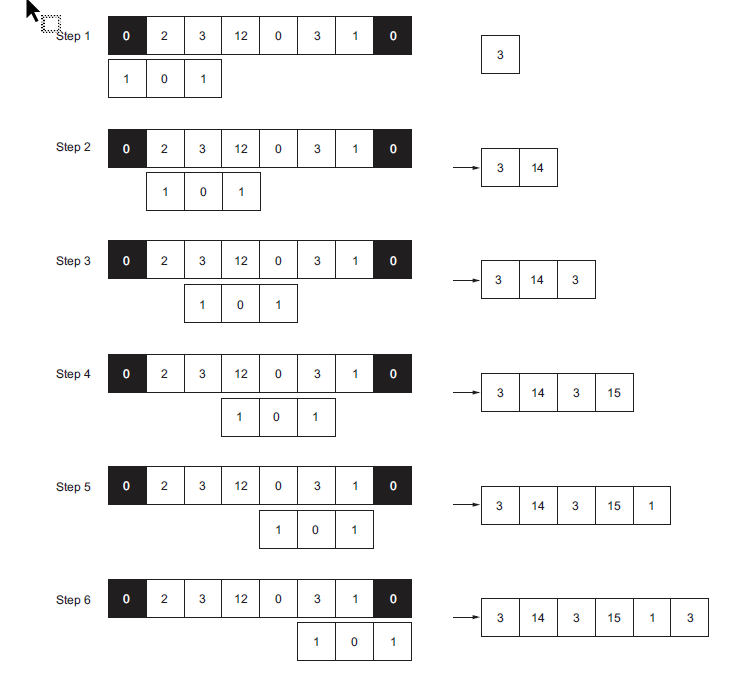

## 16.2 Implementing a CNN
As in previous chapters, we’ll implement the CNN architecture as a single-step model, a multi-step model, and a multi-output model. The single-step model will predict the traffic volume for the next timestep only, the multi-step model will predict the traffic volume for the next 24 hours, and the multi-output model will predict the temperature and traffic volume at the next timestep.

In this chapter, we’ll also combine the CNN architecture with the LSTM architecture. It can be interesting to see if filtering our time series with a convolution layer and then processing the filtered sequence with an LSTM will improve the accuracy of our predictions. Thus, we’ll implement both a CNN only, and the combination of a CNN with an LSTM. 

Of course, the other prerequisite is to read the training set, the validation set, and the test set, so let’s do that right now.

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

tf.random.set_seed(42)
np.random.seed(42)

2022-10-09 17:46:28.037374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 17:46:28.205688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 17:46:28.205716: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-09 17:46:28.286465: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 17:46:29.457382: W tensorflow/stream_executor/platform/de

In [2]:
train_df = pd.read_csv('./train.csv', index_col=0)
val_df = pd.read_csv('./val.csv', index_col=0)
test_df = pd.read_csv('./test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(24544, 15) (7013, 15) (3507, 15)


In [3]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [4]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [5]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### 16.2.1 Implementing a CNN as a single-step model

We’ll start by implementing a CNN as a single-step model. Recall that the single-step model outputs a prediction for traffic volume at the next timestep using the last known feature.

In this case, however, it does not make sense to provide the CNN model with only one timestep as an input because we want to run a convolution. We will instead use three input values to generate a prediction for the next timestep. That way we’ll have a sequence of data on which we can run a convolution operation. Furthermore, our input sequence must have a length at least equal to the kernel’s length, which in our case is 3. Recall that we expressed the relationship between the input length, kernel length, and output length in equation 16.1:

output length = input length – kernel length + 1

In this equation, no length can be equal to 0, since that would mean that no data is being processed or output. The condition that no length can be 0 is only satisfied if the input length is greater than or equal to the kernel length. Therefore, our input sequence must have at least three timesteps.

We can thus define the data window that will be used to train the model.

In [6]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['NO2'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['NO2'])

# Values obtained from chapter 15

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

With all the data windows ready, we can define our CNN model. Again, we’ll use the Sequential model from Keras to stack different layers. Then we’ll use the Conv1D layer, as we are working with time series, and the kernel only moves in the temporal dimension. The filters parameter is equivalent to the units parameter of the Dense layer, and it simply represents the number of neurons in the convolutional layer. We’ll set the kernel_size to the width of our kernel, which is 3. We don’t need to specify the other dimensions, as Keras will automatically take the right shape to accommodate the inputs. Then we’ll pass the output of the CNN to a Dense layer. 

That way, the model will be learning on a reduced set of features that were previously filtered by the convolutional step. We’ll finally output a prediction with a Dense layer of only one unit, as we are forecasting only the traffic volume for the next timestep.

In [7]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

2022-10-09 17:46:31.096865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 17:46:31.096986: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 17:46:31.097017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deedevelopment): /proc/driver/nvidia/version does not exist
2022-10-09 17:46:31.097383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
767/767 [==============================] - 5s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0420 - val_loss: 0.0025 - val_mean_absolute_error: 0.0401
Epoch 2/50
767/767 [==============================] - 3s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0312 - val_loss: 0.0021 - val_mean_absolute_error: 0.0361
Epoch 3/50
767/767 [==============================] - 3s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0304 - val_loss: 0.0019 - val_mean_absolute_error: 0.0341
Epoch 4/50
767/767 [==============================] - 3s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0303 - val_loss: 0.0015 - val_mean_absolute_error: 0.0271
Epoch 5/50
767/767 [==============================] - 3s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0296 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 6/50
767/767 [==============================] - 3s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0296 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 7/50
767/7

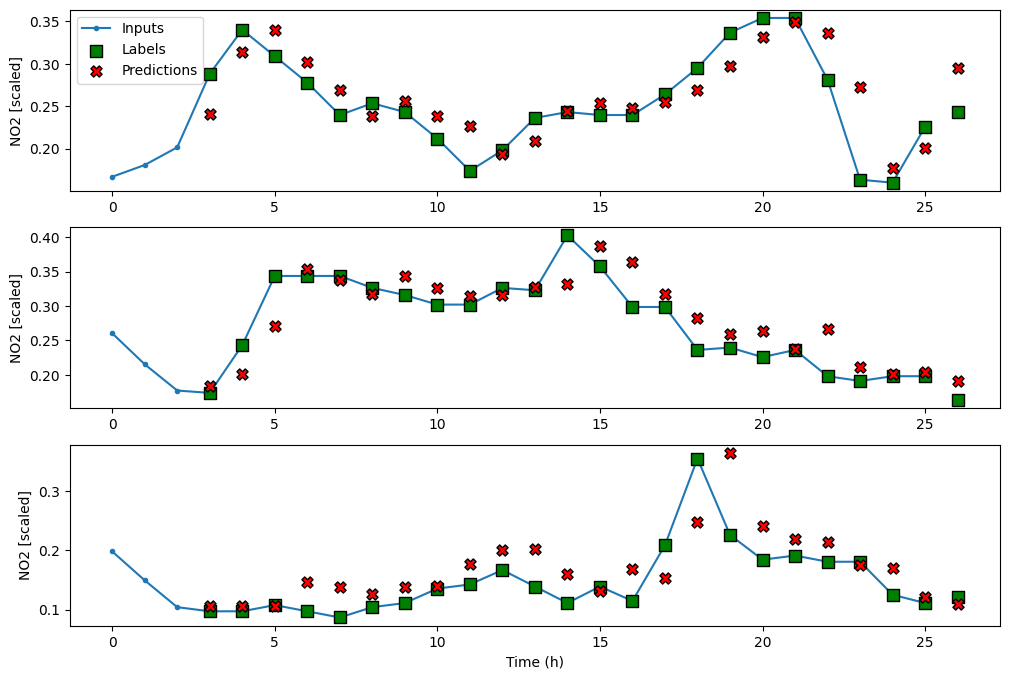

In [8]:
wide_conv_window.plot(cnn_model)

As you can see in figure 16.5, many predictions overlap labels, meaning that we have fairly accurate predictions. Of course, we must compare this model’s performance metrics to those of the other models to properly assess its performance.

Before doing that, let’s combine the CNN and LSTM architectures into a single model.

You saw in the previous chapter how the LSTM architecture resulted in the bestperforming models so far. Thus, it is a reasonable hypothesis that filtering our input sequence before feeding it to an LSTM might improve the performance.

Thus, we’ll follow the Conv1D layer with two LSTM layers. This is an arbitrary choice, so make sure you experiment with it later on. There is rarely only one good way of building models, so it is important to showcase what is possible.

In [9]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 14s 10ms/step - loss: 0.0049 - mean_absolute_error: 0.0475 - val_loss: 0.0018 - val_mean_absolute_error: 0.0321
Epoch 2/50
767/767 [==============================] - 7s 8ms/step - loss: 0.0021 - mean_absolute_error: 0.0319 - val_loss: 0.0016 - val_mean_absolute_error: 0.0293
Epoch 3/50
767/767 [==============================] - 6s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0306 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290
Epoch 4/50
767/767 [==============================] - 6s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0300 - val_loss: 0.0020 - val_mean_absolute_error: 0.0344
Epoch 5/50
767/767 [==============================] - 6s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0296 - val_loss: 0.0015 - val_mean_absolute_error: 0.0277
Epoch 6/50
767/767 [==============================] - 6s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0293 - val_loss: 0.0017 - val_mean_absolute_error: 0.0307
Epoch 7/50
767

With both models built and evaluated, we can look at the MAE of our newly built models in figure 16.6. As you can see, the CNN model did not perform any better than the LSTM, and the combination of CNN and LSTM resulted in a slightly higher MAE than the CNN alone.

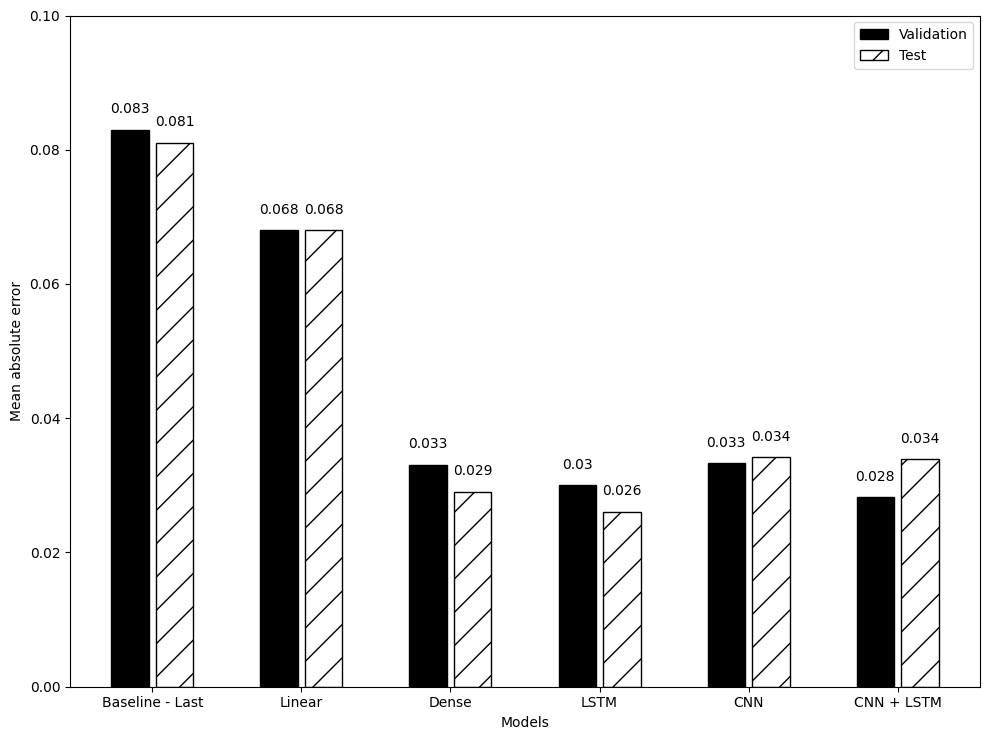

In [10]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

These results might be explained by the length of the input sequence. The model is given only an input sequence of three values, which might not be sufficient for the CNN to extract valuable features for predictions. While a CNN is better than the baseline model and the linear model, the LSTM remains the best-performing single-step model for now.

### 16.2.2 Implementing a CNN as a multi-step model

We’ll now move on to the multi-step model. Here we’ll use the last known 24 hours to forecast the traffic volume over the next 24 hours.

Again, keep in mind that the convolution reduces the length of the features, but we still expect the model to generate 24 predictions in a single shot. Therefore, we’ll reuse equation 16.2 and feed the model an input sequence with a length of 26 to make sure that we get an output of length 24. This, of course, means that we’ll keep the kernel length of 3. We can thus define our data window for the multi-step model.

In [11]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['NO2'])

# Values obtained from chapter 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

Next, we’ll define the CNN model. Again, we’ll use the Sequential model, in which we’ll stack the Conv1D layer, followed by a Dense layer with 32 neurons, and then a Dense layer with one unit, since we are predicting only traffic volume.

In [12]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
766/766 [==============================] - 5s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0864 - val_loss: 0.0095 - val_mean_absolute_error: 0.0765
Epoch 2/50
766/766 [==============================] - 4s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0824 - val_loss: 0.0090 - val_mean_absolute_error: 0.0754
Epoch 3/50
766/766 [==============================] - 4s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0818 - val_loss: 0.0087 - val_mean_absolute_error: 0.0733
Epoch 4/50
766/766 [==============================] - 4s 5ms/step - loss: 0.0113 - mean_absolute_error: 0.0811 - val_loss: 0.0100 - val_mean_absolute_error: 0.0790
Epoch 5/50
766/766 [==============================] - 3s 4ms/step - loss: 0.0111 - mean_absolute_error: 0.0806 - val_loss: 0.0090 - val_mean_absolute_error: 0.0741
Epoch 6/50
218/218 [==============================] - 1s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0809


Optionally, we can visualize the forecasts of the model using multi_window.plot(ms_cnn_model). For now, let’s skip this and combine the CNN architecture with the LSTM architecture as previously. Here we’ll simply replace the intermediate Dense layer with an LSTM layer. Once the model is defined, we can fit it and store its performance metrics.

In [13]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
766/766 [==============================] - 19s 21ms/step - loss: 0.0135 - mean_absolute_error: 0.0883 - val_loss: 0.0106 - val_mean_absolute_error: 0.0854
Epoch 2/50
766/766 [==============================] - 15s 19ms/step - loss: 0.0117 - mean_absolute_error: 0.0827 - val_loss: 0.0085 - val_mean_absolute_error: 0.0740
Epoch 3/50
766/766 [==============================] - 15s 20ms/step - loss: 0.0115 - mean_absolute_error: 0.0818 - val_loss: 0.0092 - val_mean_absolute_error: 0.0774
Epoch 4/50
766/766 [==============================] - 15s 19ms/step - loss: 0.0112 - mean_absolute_error: 0.0810 - val_loss: 0.0077 - val_mean_absolute_error: 0.0678
Epoch 5/50
766/766 [==============================] - 15s 19ms/step - loss: 0.0110 - mean_absolute_error: 0.0803 - val_loss: 0.0080 - val_mean_absolute_error: 0.0701
Epoch 6/50
766/766 [==============================] - 15s 20ms/step - loss: 0.0108 - mean_absolute_error: 0.0795 - val_loss: 0.0087 - val_mean_absolute_error: 0.0728
Epoc

With the two new models trained, we can evaluate their performance against all the multi-step models built so far. As you can see in figure 16.7, the CNN model did not improve upon the LSTM model. However, combining both models resulted in the lowest MAE of all the multi-step models, meaning that it generates the most accurate predictions. The LSTM model is thus dethroned, and we have a new winning model.

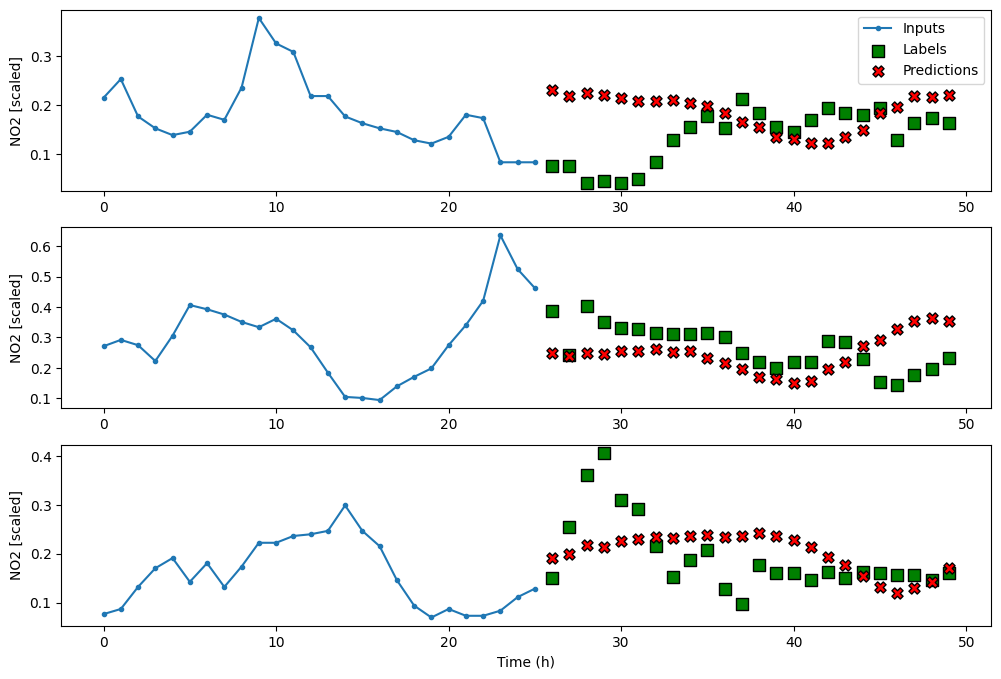

In [14]:
multi_window.plot(ms_cnn_lstm_model)

### 16.2.3 Implementing a CNN as a multi-output model

Finally, we’ll implement the CNN architecture as a multi-output model. In this case, we wish to forecast the temperature and traffic volume for the next timestep only. We have seen that giving an input sequence of length 3 was not sufficient for the CNN model to extract meaningful features, so we will use the same input length as for the multi-step model. This time, however, we are forecasting one timestep at a time over 24 timesteps.

We’ll define our data window as follows:

In [15]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['TEMP', 'NO2'])

By now you should be comfortable building models with Keras, so defining the CNN architecture as a multi-output model should be straightforward. Again, we’ll use the Sequential model, in which we’ll stack a Conv1D layer, followed by a Dense layer, allowing the network to learn on a set of filtered features. The output layer will have two neurons, since we’re forecasting both the temperature and the traffic volume.

Next we’ll fit the model and store its performance metrics.

In [16]:
# Values from chapter 15

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [17]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 5s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0391 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 2/50
767/767 [==============================] - 4s 5ms/step - loss: 0.0012 - mean_absolute_error: 0.0230 - val_loss: 8.9425e-04 - val_mean_absolute_error: 0.0202
Epoch 3/50
767/767 [==============================] - 4s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0215 - val_loss: 8.7171e-04 - val_mean_absolute_error: 0.0197
Epoch 4/50
767/767 [==============================] - 4s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0207 - val_loss: 0.0012 - val_mean_absolute_error: 0.0241
Epoch 5/50
767/767 [==============================] - 4s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0205 - val_loss: 8.0647e-04 - val_mean_absolute_error: 0.0184
Epoch 6/50
767/767 [==============================] - 4s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0202 - val_loss: 8.8395e-04 - val_mean_absolute_error: 0.0204


We can also combine the CNN architecture with the LSTM architecture as done previously.

We’ll simply replace the intermediate Dense layer with an LSTM layer, fit the model, and store its metrics.

In [18]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 19s 20ms/step - loss: 0.0040 - mean_absolute_error: 0.0401 - val_loss: 0.0011 - val_mean_absolute_error: 0.0237
Epoch 2/50
767/767 [==============================] - 15s 19ms/step - loss: 0.0012 - mean_absolute_error: 0.0232 - val_loss: 9.2837e-04 - val_mean_absolute_error: 0.0210
Epoch 3/50
767/767 [==============================] - 15s 19ms/step - loss: 0.0011 - mean_absolute_error: 0.0214 - val_loss: 8.4489e-04 - val_mean_absolute_error: 0.0192
Epoch 4/50
767/767 [==============================] - 15s 20ms/step - loss: 0.0011 - mean_absolute_error: 0.0207 - val_loss: 8.1119e-04 - val_mean_absolute_error: 0.0187
Epoch 5/50
767/767 [==============================] - 15s 19ms/step - loss: 0.0010 - mean_absolute_error: 0.0203 - val_loss: 0.0010 - val_mean_absolute_error: 0.0219
Epoch 6/50
767/767 [==============================] - 15s 19ms/step - loss: 0.0010 - mean_absolute_error: 0.0201 - val_loss: 8.3782e-04 - val_mean_absolute_er

As usual, we’ll compare the performance of the new models with the previous multioutput models in figure 16.8. You’ll notice that the CNN, and the combination of CNN and LSTM, did not result in an improvement over the LSTM. In fact, all three models achieve the same MAE.

Explaining this behavior is hard, as deep learning models are black boxes, meaning that they are hard to interpret. While they can be very performant, the tradeoff lies in their explicability. Methods to interpret neural network models do exist, but they are outside of the scope of this book. If you want to learn more, take a look at Christof Molnar’s book, Interpretable Machine Learning, Second Edition (https://christophm.github.io/interpretable-ml-book/).

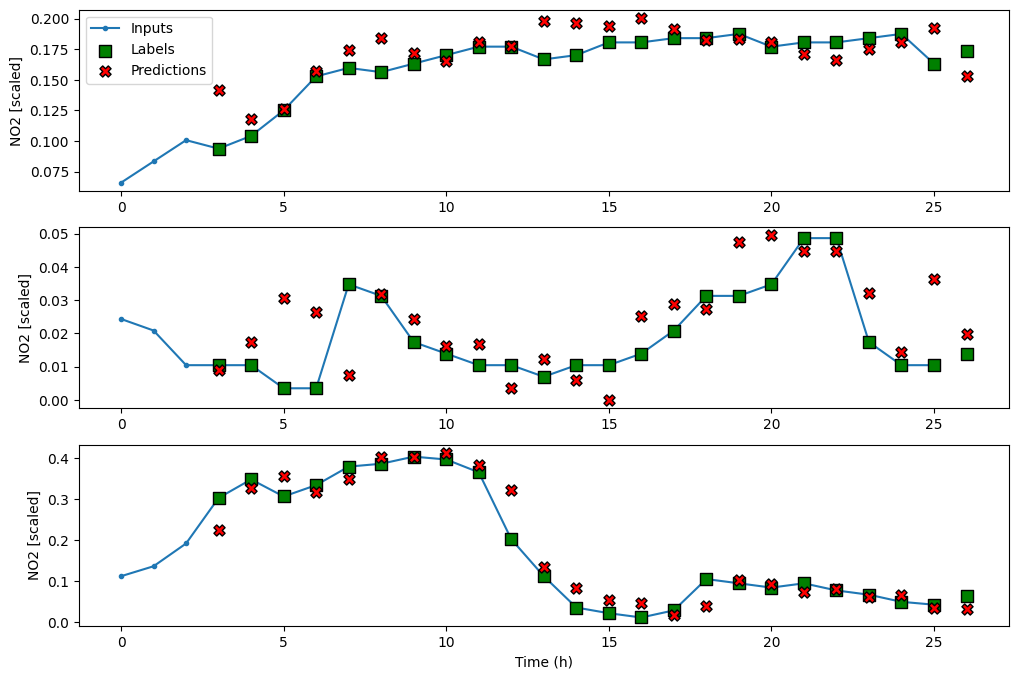

In [19]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

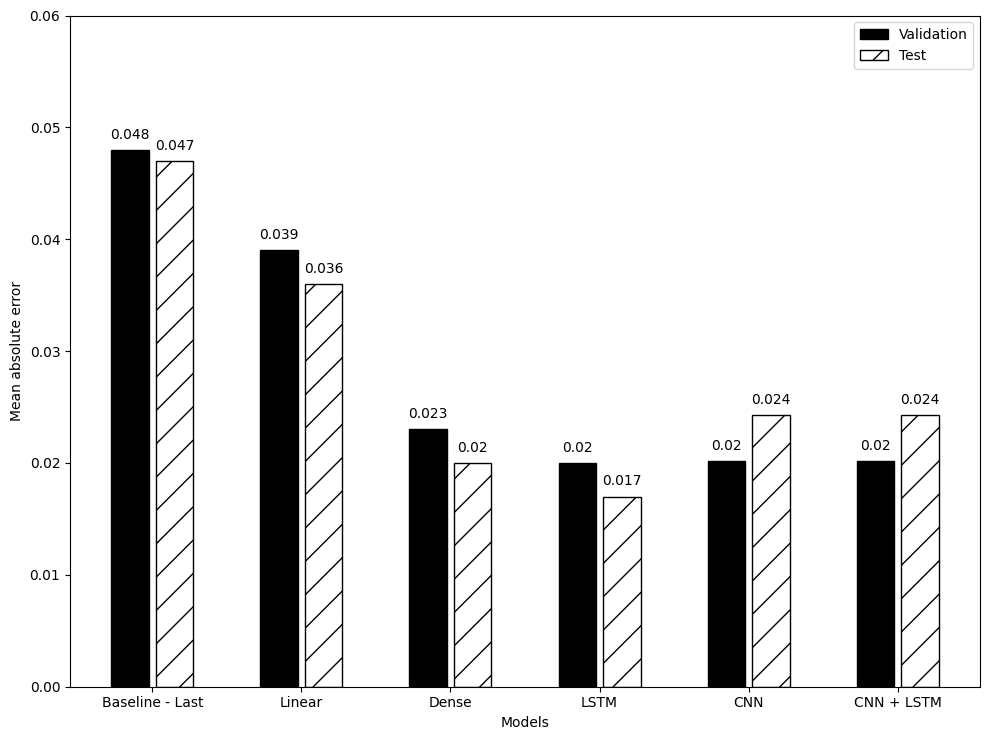

In [20]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()